In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import torch.nn.functional as F

np.random.seed(1)
torch.manual_seed(1)

In [7]:
train = pd.read_csv('cleantrain2nahan.csv')
test = pd.read_csv('cleantest2nahan.csv')

In [8]:
train

,Target,demog_1,demog_2,income,demog_3,city_tier,occupation,demog_4,demog_5,demog_6,...,others_40,others_41,txn_80,txn_81,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
0,1.0,55.0,1.0,1,101.0,2,2,6,4.000000,1.0,...,0.0,0.0,1621.000000,32.000000,1.0,1,0,1.0,1.0,0
1,1.0,55.0,2.0,1,101.0,8,5,6,3.272397,1.0,...,0.0,0.0,8.000000,8.000000,1.0,1,0,1.0,1.0,0
2,1.0,53.0,2.0,6,101.0,1,5,6,4.000000,1.0,...,0.0,0.0,15.000000,22.000000,1.0,1,2,1.0,1.0,2
3,1.0,55.0,3.0,2,101.0,1,5,6,3.000000,1.0,...,0.0,0.0,62.000000,184.000000,1.0,1,2,1.0,1.0,0
4,1.0,56.0,2.0,1,101.0,7,5,6,2.000000,1.0,...,0.0,0.0,3634.000000,22.926162,1.0,1,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,0.0,53.0,3.0,6,101.0,1,5,6,4.000000,1.0,...,0.0,0.0,34.442252,9.000000,1.0,1,0,1.0,1.0,2
51257,0.0,55.0,1.0,1,101.0,3,2,6,3.000000,1.0,...,0.0,0.0,3.000000,5.000000,1.0,1,2,1.0,1.0,2
51258,0.0,401.0,4.0,0,103.0,4,0,6,3.000000,1.0,...,0.0,0.0,34.442252,22.926162,1.0,0,0,1.0,1.0,2
51259,0.0,55.0,6.0,0,101.0,7,6,6,4.000000,1.0,...,0.0,0.0,34.442252,22.926162,1.0,1,1,1.0,1.0,2


In [9]:
txn_cols = train.filter(regex='txn').columns
txn_cols

Index(['txn_1', 'txn_2', 'txn_3', 'txn_4', 'txn_5', 'txn_6', 'txn_7', 'txn_8',
       'txn_9', 'txn_10', 'txn_11', 'txn_12', 'txn_13', 'txn_14', 'txn_15',
       'txn_16', 'txn_17', 'txn_18', 'txn_19', 'txn_20', 'txn_21', 'txn_22',
       'txn_23', 'txn_24', 'txn_25', 'txn_26', 'txn_27', 'txn_28', 'txn_29',
       'txn_30', 'txn_31', 'txn_32', 'txn_33', 'txn_34', 'txn_35', 'txn_36',
       'txn_37', 'txn_38', 'txn_39', 'txn_40', 'txn_41', 'txn_42', 'txn_43',
       'txn_44', 'txn_45', 'txn_46', 'txn_47', 'txn_48', 'txn_49', 'txn_50',
       'txn_51', 'txn_52', 'txn_53', 'txn_54', 'txn_55', 'txn_56', 'txn_57',
       'txn_58', 'txn_59', 'txn_60', 'txn_61', 'txn_62', 'txn_63', 'txn_64',
       'txn_65', 'txn_66', 'txn_67', 'txn_68', 'txn_69', 'txn_70', 'txn_71',
       'txn_72', 'txn_73', 'txn_74', 'txn_75', 'txn_76', 'txn_77', 'txn_78',
       'txn_79', 'txn_80', 'txn_81'],
      dtype='object')

In [10]:
y_train = train['Target']
train.drop(columns=['Target'], inplace=True)
X_train1 = train.drop(columns=txn_cols)
X_train2 = train[txn_cols]

y_test = test['Target']
test.drop(columns=['Target'], inplace=True)
X_test1 = test.drop(columns=txn_cols)
X_test2 = test[txn_cols]

In [6]:
X_train1

,demog_1,demog_2,income,demog_3,city_tier,occupation,demog_4,demog_5,demog_6,demog_7,...,others_38,others_39,others_40,others_41,demog_39,email_domain,demog_40,demog_41,demog_42,demog_43
0,55.0,1.0,1,101.0,2,2,6,4.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,0,1.0,1.0,0
1,55.0,2.0,1,101.0,8,5,6,3.272397,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,0,1.0,1.0,0
2,53.0,2.0,6,101.0,1,5,6,4.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,2,1.0,1.0,2
3,55.0,3.0,2,101.0,1,5,6,3.000000,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1,2,1.0,1.0,0
4,56.0,2.0,1,101.0,7,5,6,2.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,53.0,3.0,6,101.0,1,5,6,4.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,0,1.0,1.0,2
51257,55.0,1.0,1,101.0,3,2,6,3.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1,2,1.0,1.0,2
51258,401.0,4.0,0,103.0,4,0,6,3.000000,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0,0,1.0,1.0,2
51259,55.0,6.0,0,101.0,7,6,6,4.000000,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1,1,1.0,1.0,2


In [7]:
X_train2

,txn_1,txn_2,txn_3,txn_4,txn_5,txn_6,txn_7,txn_8,txn_9,txn_10,...,txn_72,txn_73,txn_74,txn_75,txn_76,txn_77,txn_78,txn_79,txn_80,txn_81
0,10.0,10.0,0.0,0.0,35.0,35.0,55.0,55.0,4.0,4.0,...,0.0,69.0,69.0,1658.0,1658.0,0.00000,0.000000,0.000000,1621.000000,32.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,...,0.0,14.0,14.0,8.0,8.0,1.00000,0.000000,0.000000,8.000000,8.000000
2,0.0,0.0,1.0,1.0,0.0,0.0,5.0,5.0,24.0,24.0,...,0.0,27.0,27.0,18.0,18.0,0.00000,1.000000,1.000000,15.000000,22.000000
3,10.0,12.0,3.0,4.0,10.0,61.0,10.0,18.0,249.0,252.0,...,0.0,297.0,353.0,48.0,66.0,0.00000,0.000000,0.000000,62.000000,184.000000
4,0.0,0.0,0.0,0.0,95.0,95.0,1.0,1.0,0.0,0.0,...,0.0,95.0,95.0,3689.0,3689.0,0.00000,0.000000,0.000000,3634.000000,22.926162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,19.0,1.0,3.0,16.00000,4.000000,4.000000,34.442252,9.000000
51257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,...,0.0,8.0,29.0,2.0,10.0,13.00000,4.000000,4.000000,3.000000,5.000000
51258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,3.0,22.00000,4.000000,4.000000,34.442252,22.926162
51259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,22.34285,4.712211,15.561711,34.442252,22.926162


In [11]:
for i in X_train1.columns:
    scaler = MinMaxScaler()
    scaler.fit(X_train1[i].values.reshape(-1,1))
    scaler.fit(X_test1[i].values.reshape(-1,1))
    X_train1[i] = scaler.transform(X_train1[i].values.reshape(-1,1))
    X_test1[i] = scaler.transform(X_test1[i].values.reshape(-1,1))
X_train1 = np.array(X_train1)
X_test1 = np.array(X_test1)

In [12]:
scaler = MinMaxScaler()
scaler.fit(X_train2)
scaler.fit(X_test2)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Taking the last time step output
        return out  

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Taking the last time step output
        return out
    
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Taking the last time step output
        return out
    
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Taking the last time step output
        return out

class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.fc(x)
        return out


class CombinedModel(nn.Module):
    def __init__(self, rnn_model, linear_model, input_size):
        super(CombinedModel, self).__init__()
        self.rnn_model = rnn_model
        self.linear_model = linear_model
        self.final_linear = nn.Linear(input_size, 2)
        self.softmax = nn.Softmax()

    def forward(self, x_rnn, x_linear):
        out_rnn = self.rnn_model(x_rnn)
        out_linear = self.linear_model(x_linear)
        combined_output = torch.cat((out_rnn, out_linear), dim=1)
        final_output = self.final_linear(combined_output)
        return self.softmax(final_output)


In [23]:
# Instantiate the models
rnn_model = RNNModel(input_size=1, hidden_size=4, output_size=2)
linear_model = LinearModel(input_size=89, output_size=8)
combined_model1 = CombinedModel(rnn_model, linear_model, 10).cuda()

# Write train loop for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model1.parameters(), lr=0.015)

dataLoader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.Tensor(X_train2).unsqueeze(-1).cuda(),
        torch.Tensor(X_train1).cuda(),
        torch.Tensor(y_train.values).cuda()
    ),
    batch_size=32,
    shuffle=True
)

num_epochs = 1000
train_loss_rnn = []
test_loss_rnn = []

for epoch in tqdm(range(num_epochs)):
    loss_train = 0
    for data in dataLoader:
        x_rnn, x_linear, y = data
        optimizer.zero_grad()
        outputs = combined_model1(x_rnn, x_linear)
        loss = criterion(outputs.float(), y.to(torch.int64))
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
    
    train_loss_rnn.append(loss_train / len(dataLoader))
    
    # with torch.no_grad():
        # Apply softmax to the test predictions
    # combined_model1.eval()
    test_outputs = combined_model1(
        torch.Tensor(X_test2).unsqueeze(-1).cuda(),
        torch.Tensor(X_test1).cuda()
    )
    test_outputs = torch.nn.functional.softmax(test_outputs, dim=1)
    
    # Calculate test loss
    test_loss = criterion(test_outputs, torch.Tensor(y_test.values).long().cuda())
    test_loss_rnn.append(test_loss.item())


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

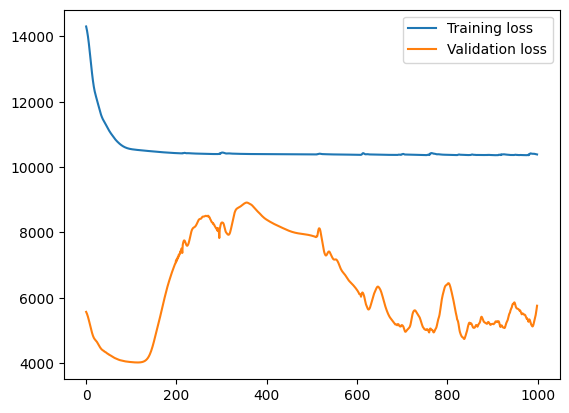

In [ ]:
plt.plot(range(1000),train_loss_rnn, label='Training loss')
plt.plot(range(1000),test_loss_rnn, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred = combined_model(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze().detach().numpy()

In [ ]:
# auc(y_test, y_pred)

ValueError: x is neither increasing nor decreasing : [0. 0. 0. ... 0. 0. 0.].

In [ ]:
np.unique(y_pred, return_counts=True)

(array([-99.63229 , -97.27472 , -91.851074, ..., -33.459076, -28.561134,
        -21.194427], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))

In [ ]:
# Method 2: GRU
# Instantiate the models
gru_model = GRUModel(input_size=1, hidden_size=4, output_size=2)
linear_model = LinearModel(input_size=89, output_size=8)
combined_model = CombinedModel(gru_model, linear_model, 10)


#Write train loop for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.parameters(), lr=0.01)

num_epochs = 300
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    combined_model.train()
    optimizer.zero_grad()
    y_pred = combined_model(torch.Tensor(X_train2).unsqueeze(-1),torch.Tensor(X_train1))
    loss = criterion(y_pred.squeeze(),torch.Tensor(y_train.values))
    loss.backward()
    optimizer.step()
    teloss = criterion(combined_model(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze(),torch.Tensor(y_test.values))
    test_loss.append(teloss.item())
    train_loss.append(loss.item())
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 	Loss: 14366.089844
Epoch: 2 	Loss: 14299.585938
Epoch: 3 	Loss: 14234.214844
Epoch: 4 	Loss: 14166.591797
Epoch: 5 	Loss: 14095.576172
Epoch: 6 	Loss: 14021.064453
Epoch: 7 	Loss: 13943.169922
Epoch: 8 	Loss: 13862.128906
Epoch: 9 	Loss: 13778.270508
Epoch: 10 	Loss: 13692.006836
Epoch: 11 	Loss: 13603.839844
Epoch: 12 	Loss: 13514.367188
Epoch: 13 	Loss: 13424.254883
Epoch: 14 	Loss: 13334.189453
Epoch: 15 	Loss: 13244.817383
Epoch: 16 	Loss: 13156.666016
Epoch: 17 	Loss: 13070.154297
Epoch: 18 	Loss: 12985.661133
Epoch: 19 	Loss: 12903.606445
Epoch: 20 	Loss: 12824.459961
Epoch: 21 	Loss: 12748.697266
Epoch: 22 	Loss: 12676.772461
Epoch: 23 	Loss: 12609.049805
Epoch: 24 	Loss: 12545.800781
Epoch: 25 	Loss: 12487.119141
Epoch: 26 	Loss: 12432.868164
Epoch: 27 	Loss: 12382.601562
Epoch: 28 	Loss: 12335.654297
Epoch: 29 	Loss: 12291.246094
Epoch: 30 	Loss: 12248.549805
Epoch: 31 	Loss: 12206.677734
Epoch: 32 	Loss: 12164.791016
Epoch: 33 	Loss: 12122.580078
Epoch: 34 	Loss: 12

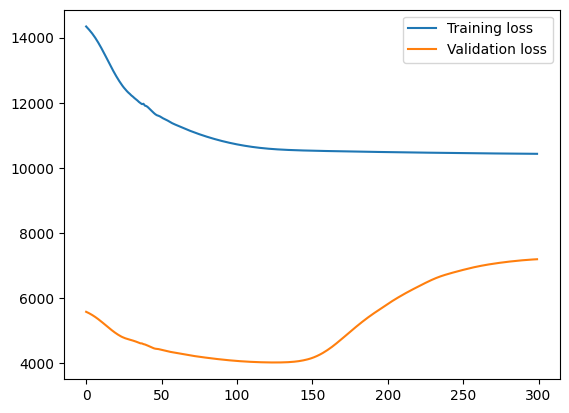

In [ ]:
plt.plot(range(300),train_loss, label='Training loss')
plt.plot(range(300),test_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_gru = combined_model(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze().detach().numpy()

In [ ]:
#Method 3: LSTM
# Instantiate the models
lstm_model = LSTMModel(input_size=1, hidden_size=4, output_size=2)
linear_model = LinearModel(input_size=89, output_size=8)
combined_model3 = CombinedModel(lstm_model, linear_model, 10)


#Write train loop for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model3.parameters(), lr=0.01)

num_epochs = 300
train_loss = []
test_loss = []

for epoch in range(num_epochs):
    combined_model3.train()
    optimizer.zero_grad()
    y_pred = combined_model3(torch.Tensor(X_train2).unsqueeze(-1),torch.Tensor(X_train1))
    loss = criterion(y_pred.squeeze(),torch.Tensor(y_train.values))
    loss.backward()
    optimizer.step()
    teloss = criterion(combined_model3(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze(),torch.Tensor(y_test.values))
    test_loss.append(teloss.item())
    train_loss.append(loss.item())
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch + 1, loss.item()))

Epoch: 1 	Loss: 14403.511719
Epoch: 2 	Loss: 14331.110352
Epoch: 3 	Loss: 14262.648438
Epoch: 4 	Loss: 14195.857422
Epoch: 5 	Loss: 14128.075195
Epoch: 6 	Loss: 14057.480469
Epoch: 7 	Loss: 13983.337891
Epoch: 8 	Loss: 13905.550781
Epoch: 9 	Loss: 13824.326172
Epoch: 10 	Loss: 13740.036133
Epoch: 11 	Loss: 13653.174805
Epoch: 12 	Loss: 13564.314453
Epoch: 13 	Loss: 13474.103516
Epoch: 14 	Loss: 13383.250000
Epoch: 15 	Loss: 13292.518555
Epoch: 16 	Loss: 13202.697266
Epoch: 17 	Loss: 13114.529297
Epoch: 18 	Loss: 13028.663086
Epoch: 19 	Loss: 12945.599609
Epoch: 20 	Loss: 12865.724609
Epoch: 21 	Loss: 12789.373047
Epoch: 22 	Loss: 12716.881836
Epoch: 23 	Loss: 12648.612305
Epoch: 24 	Loss: 12584.933594
Epoch: 25 	Loss: 12526.189453
Epoch: 26 	Loss: 12472.625000
Epoch: 27 	Loss: 12424.287109
Epoch: 28 	Loss: 12380.943359
Epoch: 29 	Loss: 12342.036133
Epoch: 30 	Loss: 12306.764648
Epoch: 31 	Loss: 12274.223633
Epoch: 32 	Loss: 12243.523438
Epoch: 33 	Loss: 12213.795898
Epoch: 34 	Loss: 12

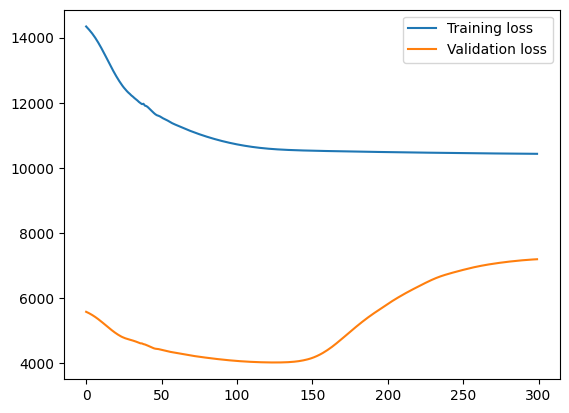

In [ ]:
plt.plot(range(300),train_loss, label='Training loss')
plt.plot(range(300),test_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = combined_model3(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze().detach().numpy()

In [ ]:
#Method 4: BiLSTM
# Instantiate the models
bilstm_model = BiLSTMModel(input_size=1, hidden_size=4, output_size=2)
linear_model = LinearModel(input_size=89, output_size=8)
combined_model4 = CombinedModel(bilstm_model, linear_model, 10).cuda()


#Write train loop for our model
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model4.parameters(), lr=0.01)

num_epochs = 1000
train_loss_bilstm = []
test_loss_bilstm = []

for epoch in range(num_epochs):
    combined_model4.train()
    optimizer.zero_grad()
    y_pred = combined_model4(torch.Tensor(X_train2).unsqueeze(-1).cuda(),torch.Tensor(X_train1).cuda())
    loss = criterion(y_pred.squeeze(),torch.Tensor(y_train.values).cuda())
    loss.backward()
    optimizer.step()
    teloss = criterion(combined_model4(torch.Tensor(X_test2).unsqueeze(-1).cuda(),torch.Tensor(X_test1)).squeeze().cuda(),torch.Tensor(y_test.values).cuda())
    test_loss.append(teloss.item())
    train_loss.append(loss.item())
    print('Epoch: {} \tLoss: {:.6f}'.format(epoch + 1, loss.item()))

RuntimeError: CUDA error: CUDA-capable device(s) is/are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


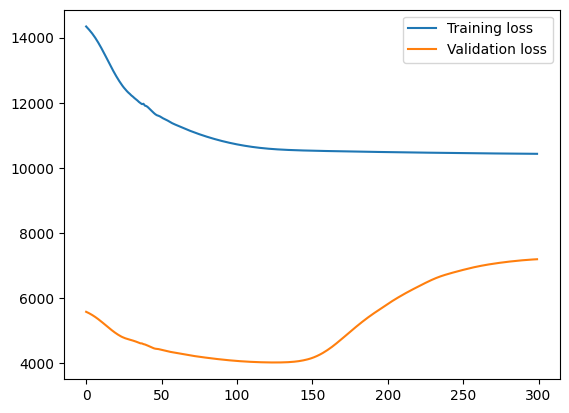

In [ ]:
plt.plot(range(300),train_loss, label='Training loss')
plt.plot(range(300),test_loss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
y_pred_bilstm = combined_model4(torch.Tensor(X_test2).unsqueeze(-1),torch.Tensor(X_test1)).squeeze().detach().numpy()